In [1]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
LW=5 # linewidth
MS=10 # markersize

# Integration rules with respect to Gaussian measure
Alex Gorodetsky, November 2020

In this notebook we look at what nonlinear models do to Gaussian measures and how numerical quadrature is computed.

## A model setting

Lets assume we have some Gaussian distribution $X \sim \mathcal{N}(m, C)$, and that we have a nonlinear model $Y = h(X)$. We would like to estimate $\mathbb{E}\left[Y\right]$. Lets first look at the distributions of the $X$ and $Y$ variables. We will play around with the function

\begin{equation}
h(X_1,X_2) = 
\begin{bmatrix}
X_1 \tanh(X_1 X_2) \\
\sqrt{X_2^2}
\end{bmatrix}
\end{equation}

In [2]:
 def reference_cov():
    std1 = 1
    std2 = 2
    rho = 0.9
    cov = np.array([[std1*std1, rho * std1 * std2], [rho * std1 * std2, std2*std2]])
    return cov

def nonlin1(x):
    N = x.shape[0]
    out = np.zeros((x.shape[0], 2))
    out[:, 0] = x[:,0]*np.tanh(x[:, 0] * x[:, 1]) #+ np.random.randn(N)
    out[:, 1] = np.sqrt(x[:,1]**2) #np.sin(2.0 * np.pi * x[:, 0] * x[:, 1])
    return out

Now lets look at samples distributed according to $X$ and $Y$

In [3]:
def plot_points(N, cov, func, tpoints):
    """Plot a Gaussian and a Transformed Variable

    Inputs
    ------
    N: number of samples
    cov: covariance of the gaussian
    func: nonlinear function to visualize
    tpoints: (N, 2) array of any special input points we might want to see transformed

    Returns
    -------
    fig, axs, tpt
    tpt is (N, 2) array of transformed points or none if tpoints is None
    """

    # Sample from the Gaussian (mean 0)
    L = np.linalg.cholesky(cov)
    x = np.dot(L, np.random.randn(2, N)).T

    # Plot the "original" points
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(x[:, 0], x[:, 1], 'o', ms=1)
    #axs[0].plot(0, 0, 'o', color='black', ms=10)
    if tpoints is not None:
        axs[0].plot(tpoints[:, 0], tpoints[:, 1], 'go', ms=10)
    axs[0].set_title("Original", fontsize=14)
    axs[0].set_xlabel(r'$X_1$', fontsize=14)
    axs[0].set_ylabel(r'$X_2$', fontsize=14)

    xt = func(x)
    axs[1].plot(xt[:, 0], xt[:, 1], 'ro', ms=1)
    #mt = np.mean(xt, axis=0)
    #axs[1].plot(mt[0], mt[1], 'o', color='black', ms=10)

    tpt = None
    if tpoints is not None:
        tpt = func(tpoints)
        axs[1].plot(tpt[:, 0], tpt[:, 1], 'go', ms=10)
    axs[1].set_title("Transformed", fontsize=14)
    axs[1].set_xlabel(r'$Y_1$', fontsize=14)
    axs[1].set_ylabel(r'$Y_2$', fontsize=14)

    return fig, axs, tpt

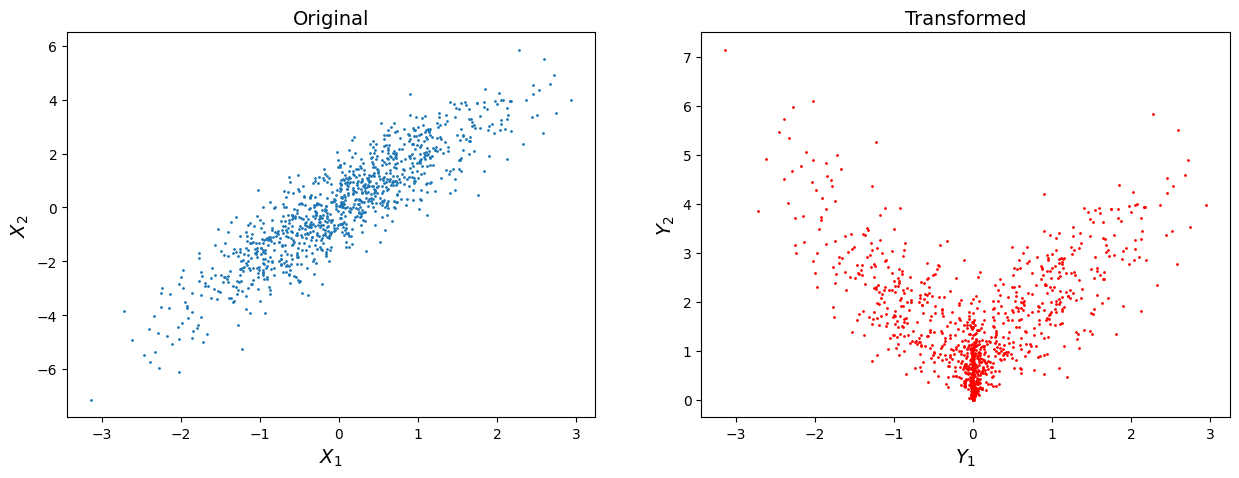

In [4]:
fig, axs, _ = plot_points(1000, reference_cov(), nonlin1, None)

## Unscented transform

The unscented transform is a quadrature rule for integrating functions with respect to Gaussian measure. It has three tunable parameters $(\alpha, \beta, \kappa)$, these parameters govern the spread the quadrature points. An unscented transform rule has $2d+1$ quadrature points, where $d$ is the dimension of the space.

In [5]:
def unscented_points(mean, cov, alg='chol', alpha=1, beta=0, kappa=0):
    """Generate unscented points"""
    dim = cov.shape[0]
    lam = alpha*alpha*(dim + kappa) - dim
    if alg == "chol":
        L = np.linalg.cholesky(cov)
    elif alg == "svd":
        u, s, v = np.linalg.svd(cov)
        L = np.dot(u, np.sqrt(np.diag(s)))
    pts = np.zeros((2*dim+1, 2))
    pts[0, :] = mean
    for ii in range(1, dim+1):
        pts[ii, :] = mean + np.sqrt(dim + lam)*L[:, ii-1]
        pts[ii+dim,:] = mean - np.sqrt(dim + lam)*L[:, ii-1]

    W0m = lam / (dim + lam)
    W0C = lam / (dim + lam) + (1 - alpha*alpha + beta)
    Wim = 1/2 / (dim + lam)
    Wic = 1/2 / (dim + lam)
    return pts, (W0m, Wim, W0C, Wic)

### Results with cholesky factorization

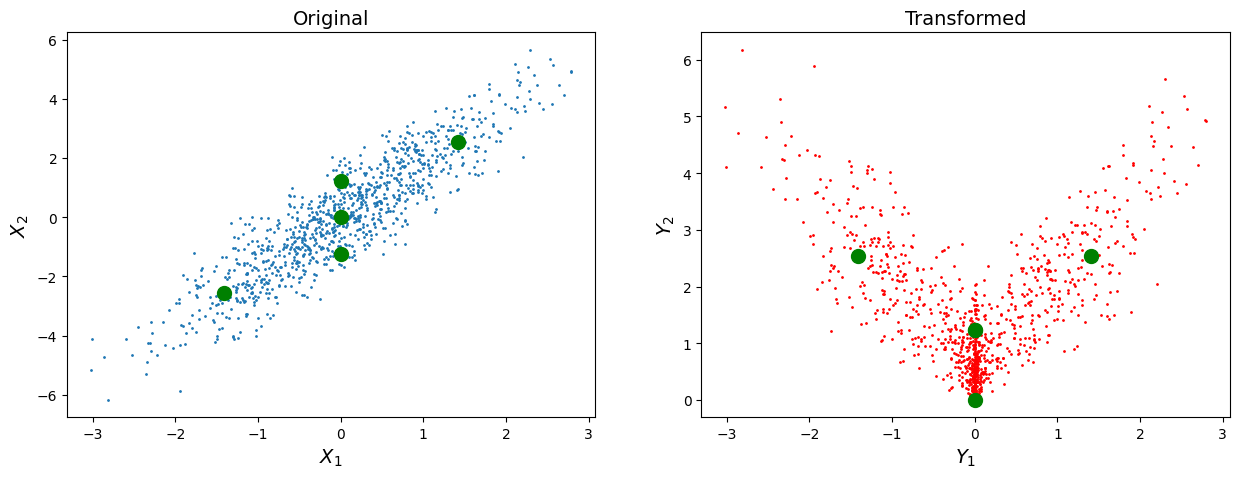

In [6]:
UP, w = unscented_points(np.zeros(2), reference_cov(), alg='chol')
UP
fig, axs, tpts = plot_points(1000, reference_cov(), nonlin1, UP)

In [7]:
UP

array([[ 0.        ,  0.        ],
       [ 1.41421356,  2.54558441],
       [ 0.        ,  1.2328828 ],
       [-1.41421356, -2.54558441],
       [ 0.        , -1.2328828 ]])

In [8]:
tpts

array([[ 0.        ,  0.        ],
       [ 1.41210347,  2.54558441],
       [ 0.        ,  1.2328828 ],
       [-1.41210347,  2.54558441],
       [-0.        ,  1.2328828 ]])

### Results with SVD

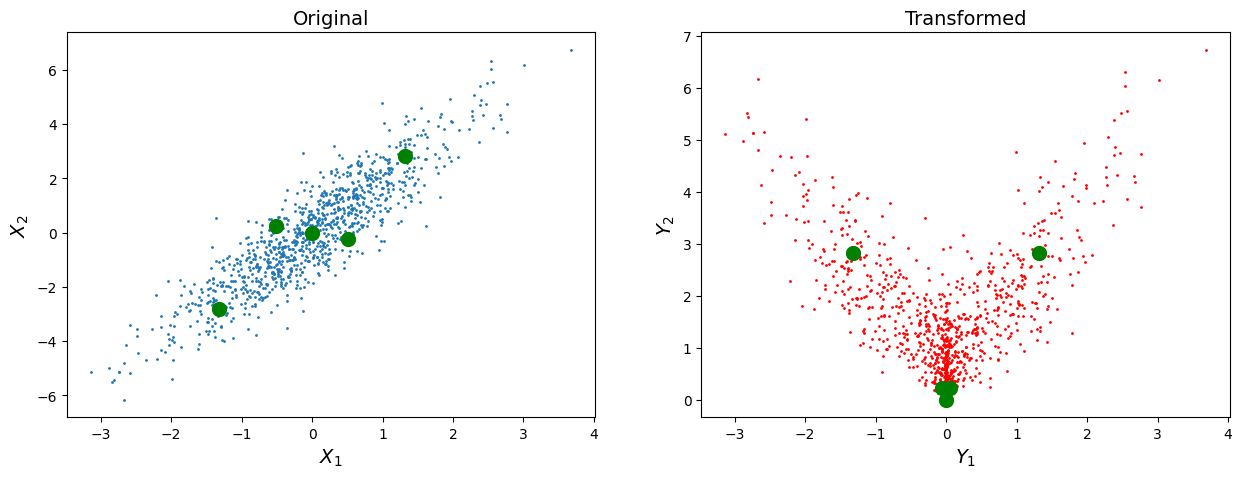

In [9]:
UP, w = unscented_points(np.zeros(2), reference_cov(), alg='svd')
fig, axs, tpts = plot_points(1000, reference_cov(), nonlin1, UP)

In [10]:
UP

array([[ 0.        ,  0.        ],
       [-1.32008102, -2.81842791],
       [-0.50733233,  0.23762175],
       [ 1.32008102,  2.81842791],
       [ 0.50733233, -0.23762175]])

In [11]:
tpts

array([[ 0.        ,  0.        ],
       [-1.31853312,  2.81842791],
       [ 0.06086596,  0.23762175],
       [ 1.31853312,  2.81842791],
       [-0.06086596,  0.23762175]])

## Gauss-hermite quadrature

Next we consider Gauss-hermite quadrature. This uses the Golub-Welsch Algorithm (read the notes)

In [12]:
def gh_oned(num_pts=2):
    """Gauss-hermite quadrature in 1D"""
    A = np.zeros((num_pts, num_pts))
    for ii in range(num_pts):
        #print("ii ", ii, ii==0, ii==(order-1))
        row = ii+1
        if ii == 0:
            A[ii, ii+1] = np.sqrt(row)
            A[ii+1, ii] = np.sqrt(row)
        elif ii == (num_pts-1):
            A[ii-1, ii] = np.sqrt(ii)
        else:
            A[ii, ii+1] = np.sqrt(row)
            A[ii+1, ii] = np.sqrt(row)
    pts, evec = np.linalg.eig(A)
    devec = np.dot(evec.T, evec)
    wts = evec[0,:]**2

    return pts, wts

def tensorize(nodes):
    """Tensorize nodes to obtain twod"""
    n1d = nodes.shape[0]
    twodnodes = np.zeros((n1d*n1d, 2))
    ind = 0
    for ii in range(n1d):
        for jj in range(n1d):
            twodnodes[ind, :] = np.array([nodes[ii], nodes[jj]])
            ind +=1
    return twodnodes

def gauss_hermite(dim, num_pts=2):
    """Gauss-hermite quadrature in 2D"""
    assert dim == 2, "Tensorize only implemented for dim=2"
    pts, weights = gh_oned(num_pts)
    ptsT = tensorize(pts)
    weightsT = tensorize(weights)
    weightsT = np.prod(weightsT, axis=1)
    return ptsT, weightsT

def rotate_points(points, mean, cov, alg="chol"):
    """Rotating points from standard gaussian to target Gaussian"""
    if alg == "chol":
        L = np.linalg.cholesky(cov)
    elif alg == "svd":
        u, s, v = np.linalg.svd(cov)
        L = np.dot(u, np.sqrt(np.diag(s)))


    new_points = np.zeros(points.shape)
    for ii in range(points.shape[0]):
        new_points[ii, :] = mean + np.dot(L, points[ii,:].T)
    return new_points

Lets add an example to show that Gaussian quadrature correctly integrates the constant, linear, and quadratic terms with only two points.

In [13]:
pts, wts = gh_oned(num_pts=2)
print(np.sum(wts), np.sum(pts*wts), np.sum(pts**2 * wts))
assert np.abs(np.sum(wts) - 1) < 1e-14            , "Constant is not integrated correctly!"
assert np.abs(np.sum(pts*wts) - 0.0) < 1e-14      , "Expectation (linear) is not computed correctly!"
assert np.abs(np.sum(pts**2 * wts) - 1.0) < 1e-14 , "Variance (quadratic) is not computed correctly!"

0.9999999999999998 0.0 0.9999999999999998


### Cholesky Square Root

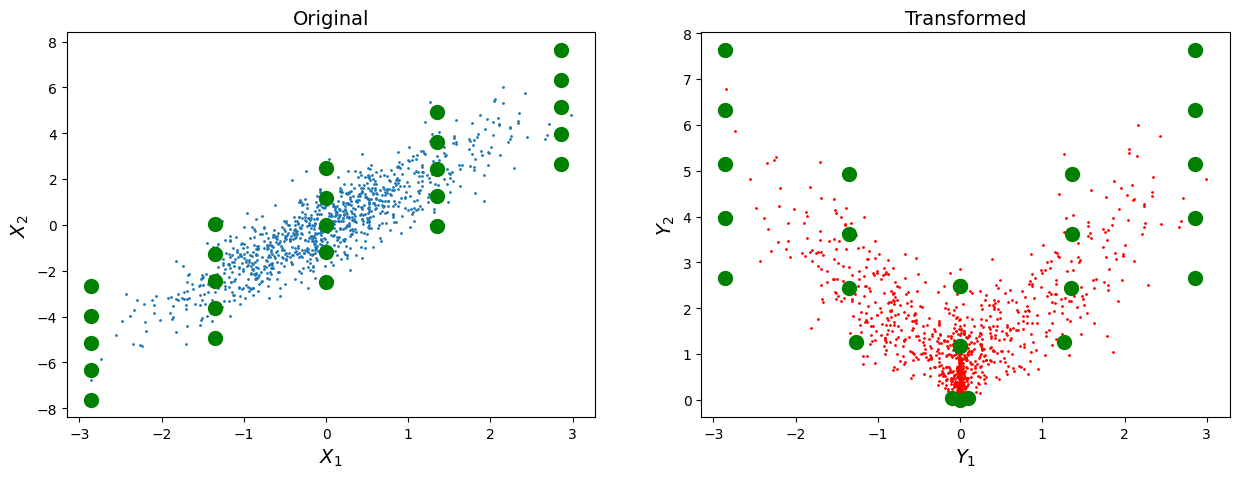

In [14]:
ghu_points, gh_w = gauss_hermite(2, num_pts=5) # unrotated quadrature nodes
gh_points = rotate_points(ghu_points, np.zeros((2)), reference_cov(), alg="chol")
fig, axs, _ = plot_points(1000, reference_cov(), nonlin1, gh_points)

### Singular value decomposition square root

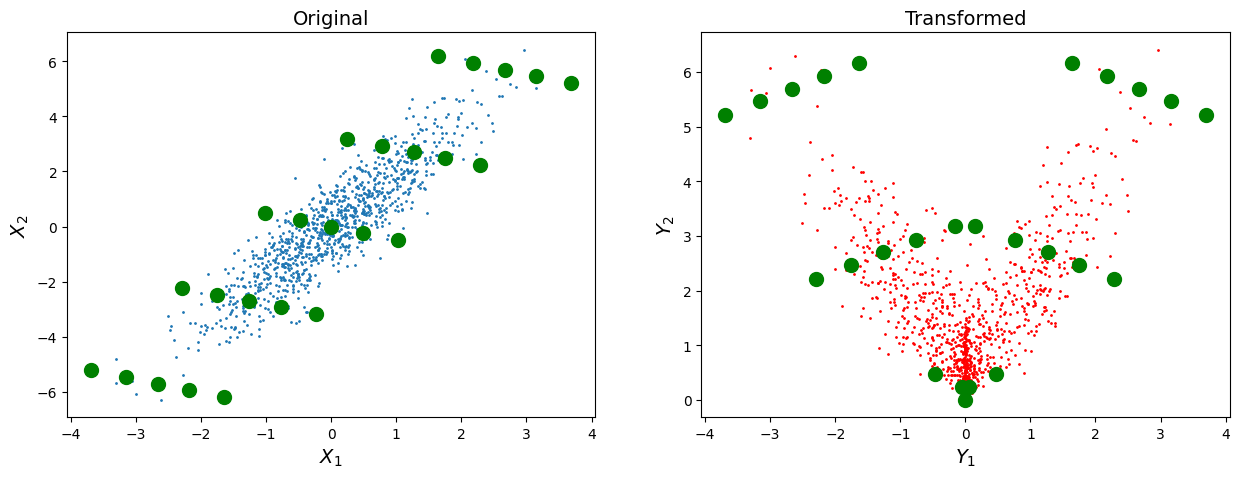

In [15]:
ghu_points, gh_w = gauss_hermite(2, num_pts=5) # unrotated quadrature nodes
gh_points = rotate_points(ghu_points, np.zeros((2)), reference_cov(), alg="svd")
fig, axs, _ = plot_points(1000, reference_cov(), nonlin1, gh_points)